In [1]:
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'

import cv2
import copy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as plt
import albumentations as A
from augraphy import *
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

print("✅ 모든 패키지 로드 완료!")


✅ 모든 패키지 로드 완료!


In [2]:
# ============================
# 나눔폰트 설정
# ============================
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 폰트 확인
try:
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in available_fonts:
        print("✅ 나눔폰트 설정 완료!")
    else:
        print("⚠️ 나눔폰트 미설치!")
        print("   터미널 실행: sudo apt-get install fonts-nanum")
        print("   설치 후 커널 재시작 필요")
except Exception as e:
    print(f"❌ 폰트 설정 오류: {e}")


✅ 나눔폰트 설정 완료!


In [ ]:
# ============================
# Augraphy Transform
# ============================
def augraphy_transform():
    """문서 전용 노이즈 증강"""
    paper_phase = [
        OneOf([
            NoiseTexturize(
                sigma_range=(5, 15),
                turbulence_range=(3, 9),
                texture_width_range=(50, 500),
                texture_height_range=(50, 500),
                p=0.5
            ),
            BrightnessTexturize(
                texturize_range=(0.8, 0.99), 
                deviation=0.02, 
                p=0.5
            ),
        ], p=0.6),
    ]
    
    post_phase = [
        OneOf([
            LightingGradient(
                light_position=None,
                direction=90,
                max_brightness=255,
                min_brightness=0,
                mode="gaussian",
                transparency=0.5,
                p=0.25
            ),
            ShadowCast(
                shadow_side="bottom",
                shadow_vertices_range=(2, 3),
                shadow_width_range=(0.5, 0.8),
                shadow_height_range=(0.5, 0.8),
                shadow_color=(0, 0, 0),
                shadow_opacity_range=(0.5, 0.6),
                shadow_iterations_range=(1, 2),
                shadow_blur_kernel_range=(101, 301),
                p=0.25
            )
        ], p=0.25),
    ]
    
    return AugraphyPipeline(
        paper_phase=paper_phase,
        post_phase=post_phase
    )


# ============================
# Albumentations Transform
# ============================
def albumentation_transform(img_h, img_w):
    """Geometric Transform + Gaussian Blur"""
    return A.Compose([
        A.Compose([
            A.LongestMaxSize(max_size=max(img_h, img_w), p=1),
            A.PadIfNeeded(
                min_height=img_h, 
                min_width=img_w, 
                border_mode=0, 
                value=(255, 255, 255), 
                p=1
            ),
            A.OneOf([
                QuarterDivide(p=0.2),
                HalfDivide(p=0.2),
                A.RandomCrop(height=img_h//2, width=img_w//2, p=0.6)
            ], p=0.55),
        ], p=0.6),

        A.OneOf([
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.Transpose(p=0.4)
        ], p=0.6),

        A.OneOf([
            A.RandomRotate90(p=0.2),
            A.ShiftScaleRotate(
                shift_limit_x=(-0.2, 0.2),
                shift_limit_y=(-0.2, 0.2),
                scale_limit=(-0.05, 0.05),
                rotate_limit=(-60, 60),
                interpolation=0,
                border_mode=0,
                value=(255, 255, 255),
                rotate_method='largest_box',
                p=0.3
            ),
        ], p=0.6),

        # GaussianBlur를 추가 (확률은 0.3~0.5 등 설계)
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0.0, p=0.4),

        A.Resize(height=img_h, width=img_w, always_apply=True, p=1.0),
    ])


# ============================
# Custom Crop Functions
# ============================

def quarter_divide(image):
    """4분할"""
    height, width, _ = image.shape
    center_x, center_y = width // 2, height // 2
    
    results = [
        image[0:center_y, 0:center_x],
        image[0:center_y, center_x:width],
        image[center_y:height, 0:center_x],
        image[center_y:height, center_x:width]
    ]
    return results[random.randint(0, 3)]


def half_divide(image):
    """2분할"""
    height, width, _ = image.shape
    center_y = height // 2
    
    results = [
        image[0:center_y, :],
        image[center_y:height, :]
    ]
    return results[random.randint(0, 1)]


class QuarterDivide(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply=always_apply, p=p)
    
    def apply(self, img, **params):
        return quarter_divide(img)


class HalfDivide(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply=always_apply, p=p)
    
    def apply(self, img, **params):
        return half_divide(img)


# ============================
# Mixup
# ============================
def mixup(image1, image2, label1, label2, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    mixup_image = lam * image1.astype(np.float32) + (1 - lam) * image2.astype(np.float32)
    mixup_label = lam * label1 + (1 - lam) * label2
    mixup_image = np.clip(mixup_image, 0, 255).astype(np.uint8)
    return mixup_image, mixup_label


print("✅ 증강 함수 정의 완료!")


✅ 증강 함수 정의 완료!


In [4]:
# ============================
# 설정
# ============================
DATA_PATH = "."
AUG_ITER = 50  # 각 이미지당 50회 증강
IMG_H, IMG_W = 380, 380
SAVE_DIR = f"train_aug_{AUG_ITER}"

print(f"📋 증강 설정:")
print(f"  - 데이터 경로: {DATA_PATH}")
print(f"  - 이미지 크기: {IMG_H}x{IMG_W}")
print(f"  - 증강 반복: {AUG_ITER}회/이미지")
print(f"  - 저장 경로: {SAVE_DIR}/")


📋 증강 설정:
  - 데이터 경로: .
  - 이미지 크기: 380x380
  - 증강 반복: 50회/이미지
  - 저장 경로: train_aug_50/


In [5]:
# ============================
# 데이터 로드
# ============================
# 중요: train_corrected.csv를 사용하세요! (수정된 레이블 포함)
df = pd.read_csv(f"{DATA_PATH}/train_corrected.csv")
meta_df = pd.read_csv(f"{DATA_PATH}/meta.csv")

# 수정된 레이블 확인
print("="*60)
print("🔍 수정된 레이블 확인")
print("="*60)
corrections_check = ["38d1796b6ad99ddd.jpg", "45f0d2dfc7e47c03.jpg", "aec62dced7af97cd.jpg"]
for img_id in corrections_check:
    row = df[df['ID'] == img_id]
    if len(row) > 0:
        print(f"  ✅ {img_id}: 타겟 = {row['target'].values[0]}")
    else:
        print(f"  ❌ {img_id}: 찾을 수 없음")

print(f"\n📊 데이터 정보:")
print(f"  - 학습 데이터: {len(df)}개")
print(f"  - 클래스 수: {len(meta_df)}개")
print(f"\n클래스별 분포:")
print(df['target'].value_counts().sort_index())


🔍 수정된 레이블 확인
  ✅ 38d1796b6ad99ddd.jpg: 타겟 = 10
  ✅ 45f0d2dfc7e47c03.jpg: 타겟 = 7
  ✅ aec62dced7af97cd.jpg: 타겟 = 14

📊 데이터 정보:
  - 학습 데이터: 1570개
  - 클래스 수: 17개

클래스별 분포:
target
0     100
1      46
2     100
3      99
4      99
5     100
6     100
7     101
8     100
9     100
10    102
11     98
12    100
13     74
14     51
15    100
16    100
Name: count, dtype: int64


In [6]:
# ============================
# Transform 준비
# ============================
aup_transform = augraphy_transform()
alb_transform = albumentation_transform(IMG_H, IMG_W)

print("✅ Transform 준비 완료!")
print("  - Augraphy: 문서 노이즈 증강")
print("  - Albumentations: Geometric 증강")


✅ Transform 준비 완료!
  - Augraphy: 문서 노이즈 증강
  - Albumentations: Geometric 증강


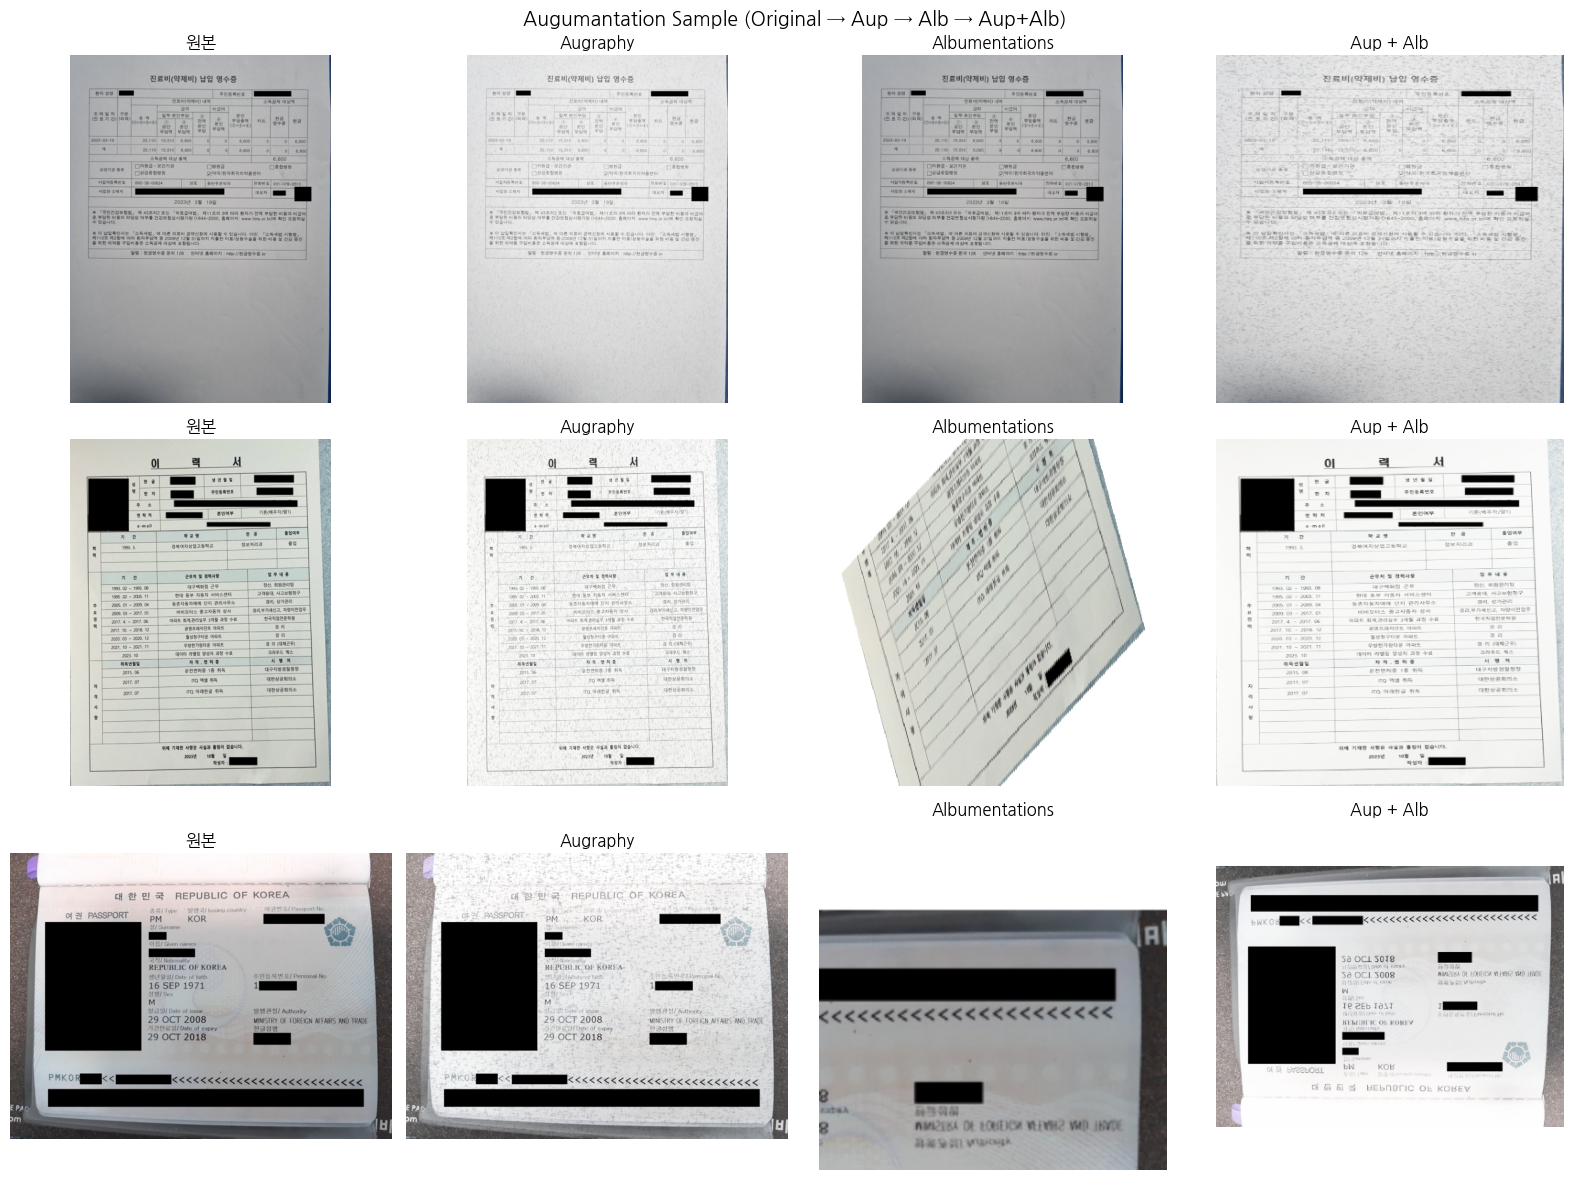

✅ 증강 샘플 확인 완료!
   → augmentation_samples.png 저장됨


In [7]:
# ============================
# 샘플 테스트 (5개만)
# ============================
import matplotlib.pyplot as plt

test_samples = df.sample(3)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Augumantation Sample (Original → Aup → Alb → Aup+Alb)', fontsize=14)

for idx, (ax_row, (_, row)) in enumerate(zip(axes, test_samples.iterrows())):
    img_path = f"{DATA_PATH}/train/{row['ID']}"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 원본
    ax_row[0].imshow(image)
    ax_row[0].set_title('원본')
    ax_row[0].axis('off')
    
    # Aup만
    aup_img = aup_transform(copy.deepcopy(image))
    ax_row[1].imshow(aup_img)
    ax_row[1].set_title('Augraphy')
    ax_row[1].axis('off')
    
    # Alb만
    alb_img = alb_transform(image=copy.deepcopy(image))['image']
    ax_row[2].imshow(alb_img)
    ax_row[2].set_title('Albumentations')
    ax_row[2].axis('off')
    
    # Aup + Alb
    combined = aup_transform(copy.deepcopy(image))
    combined = alb_transform(image=combined)['image']
    ax_row[3].imshow(combined)
    ax_row[3].set_title('Aup + Alb')
    ax_row[3].axis('off')

plt.tight_layout()
#plt.savefig('augmentation_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 증강 샘플 확인 완료!")
print("   → augmentation_samples.png 저장됨")


In [8]:
# ============================
# Offline 증강 생성
# ============================
os.makedirs(SAVE_DIR, exist_ok=True)
augmented_data = []

print(f"\n🚀 증강 시작...")
print(f"   예상 결과: {len(df)} × (1 + {AUG_ITER}×3) = {len(df) * (1 + AUG_ITER*3):,}개")
print()

for idx in tqdm(range(len(df)), desc="📦 전체 진행"):
    file_name = df.iloc[idx, 0]
    target = df.iloc[idx, 1]
    
    image_path = f"{DATA_PATH}/train/{file_name}"
    
    if not os.path.exists(image_path):
        print(f"⚠️ 파일 없음: {image_path}")
        continue
    
    image = cv2.imread(image_path)
    
    # 원본 저장
    cv2.imwrite(f"{SAVE_DIR}/{file_name}", image)
    augmented_data.append({"ID": file_name, "target": target})
    
    # 증강 (각 이미지당 AUG_ITER회)
    for i in range(AUG_ITER):
        # 1. Aup + Alb
        interm = aup_transform(copy.deepcopy(image))
        output1 = alb_transform(image=interm)['image']
        op1_name = f"aup_alb_{i:03d}_{file_name}"
        cv2.imwrite(f"{SAVE_DIR}/{op1_name}", output1)
        augmented_data.append({"ID": op1_name, "target": target})
        
        # 2. Alb만
        output2 = alb_transform(image=copy.deepcopy(image))['image']
        op2_name = f"alb_{i:03d}_{file_name}"
        cv2.imwrite(f"{SAVE_DIR}/{op2_name}", output2)
        augmented_data.append({"ID": op2_name, "target": target})
        
        # 3. Aup만
        output3 = aup_transform(copy.deepcopy(image))
        op3_name = f"aup_{i:03d}_{file_name}"
        cv2.imwrite(f"{SAVE_DIR}/{op3_name}", output3)
        augmented_data.append({"ID": op3_name, "target": target})

print("\n✅ 이미지 증강 완료!")



🚀 증강 시작...
   예상 결과: 1570 × (1 + 50×3) = 237,070개



📦 전체 진행: 100%|██████████| 1570/1570 [2:25:46<00:00,  5.57s/it] 


✅ 이미지 증강 완료!


In [11]:
# ============================
# CSV 저장
# ============================
augmented_df = pd.DataFrame(augmented_data)
csv_path = f"{DATA_PATH}/train_aug_{AUG_ITER}.csv"
augmented_df.to_csv(csv_path, index=False)

print(f"\n✅ 전체 증강 완료!")
print(f"  - 원본: {len(df):,}개")
print(f"  - 증강 후: {len(augmented_df):,}개")
print(f"  - 배수: x{len(augmented_df)/len(df):.1f}")
print(f"  - 이미지 저장: {SAVE_DIR}/")
print(f"  - CSV 저장: {csv_path}")

# 클래스별 분포 확인
print(f"\n📊 증강 후 클래스별 분포:")
print(augmented_df['target'].value_counts().sort_index())



✅ 전체 증강 완료!
  - 원본: 1,570개
  - 증강 후: 237,070개
  - 배수: x151.0
  - 이미지 저장: train_aug_50/
  - CSV 저장: ./train_aug_50.csv

📊 증강 후 클래스별 분포:
target
0     15100
1      6946
2     15100
3     14949
4     14949
5     15100
6     15100
7     15251
8     15100
9     15100
10    15402
11    14798
12    15100
13    11174
14     7701
15    15100
16    15100
Name: count, dtype: int64


In [12]:
# ============================
# 디스크 용량 확인
# ============================
import subprocess

result = subprocess.run(['du', '-sh', SAVE_DIR], capture_output=True, text=True)
print(f"\n💾 저장 용량: {result.stdout.strip()}")

# 샘플 파일 확인
sample_files = os.listdir(SAVE_DIR)[:10]
print(f"\n📂 저장된 파일 샘플 (처음 10개):")
for f in sample_files:
    print(f"  - {f}")



💾 저장 용량: 13G	train_aug_50

📂 저장된 파일 샘플 (처음 10개):
  - alb_001_642eeea5c00d9a8e.jpg
  - aup_alb_031_c4775dd3b2c001c4.jpg
  - aup_alb_044_1674ad0591a3014a.jpg
  - alb_012_43ac24060d10b7e5.jpg
  - alb_032_765341e233dcaa33.jpg
  - aup_alb_027_39aac55dba3a8184.jpg
  - aup_032_d458c9a6ba50efe9.jpg
  - aup_033_1dc625f3328476d7.jpg
  - aup_alb_039_2fef62c132543794.jpg
  - aup_035_3894573a98e02cc8.jpg
